In [1]:
from pathlib import Path
import pandas as pd
import vaex
import warnings; warnings.filterwarnings("ignore")
import numpy as np

In [2]:
# Use vaex to open and concat the parquet files
taxi = vaex.open_many(['/Users/silviawu/Downloads/YellowTaxi/Trips2018_2021/*.parquet'])
# Check the dataset length
len(taxi)

127520479

# Diagnoze the the data quality issues

In [3]:
# Add a trip duration column
taxi['trip_duration']=(taxi['tpep_dropoff_datetime']-taxi['tpep_pickup_datetime'])

In [4]:
taxi.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
data_type,int64,datetime64[us],datetime64[us],float64,float64,float64,string,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,duration[us]
count,127520479,127520479,127520479,126652068,127520479,126652068,126652068,127520479,127520479,127520479,127520479,127520479,127520479,127520479,127520479,127520479,127520479,23839165,33,127520479
NA,0,0,0,868411,0,868411,868411,0,0,0,0,0,0,0,0,0,0,103681314,127520446,0
mean,1.609570632180577,1970-01-01T16:55:53.718790,1970-01-01T17:12:31.160434,1.5710331946573506,3.0530319219556015,1.04981906809449,--,163.33529774460774,161.36566902324762,1.2987283713073254,12.997991330926455,0.47511236685363206,0.5001398863942472,1.9140168497914312,0.3392116176846199,0.29919489926451226,16.81577508377325,2.271166725009034,0.0,997441643 microseconds
std,0.517943,24797224549687.105469,24798605650037.945312,1.219065,143.929967,0.758476,--,66.57976,70.526013,0.494775,181.279923,44.283513,44.277224,2.612825,1.760307,0.443303,201.929564,0.747343,0.0,264054322207.179718
min,1,2001-01-01T00:01:55.138560,1926-08-10T21:42:07.153152,0.0,-30.62,1.0,--,1,1,0,-1259.0,-80.0,-0.5,-493.22,-52.5,-0.3,-1260.3,-2.5,0.0,-2911502763819008 microseconds
max,6,2084-11-04T12:32:52.146176,2084-11-04T12:46:17.452544,192.0,350914.89,99.0,--,265,265,5,998310.03,500000.8,500000.5,1393.56,1650.0,4000.3,1000003.8,3.0,0.0,1730218033152 microseconds


## The fields without problem
- "VendorID" field is complete and looks correct
- "PULocationID" "DOLocationID" are complete and have no abnormal values
- "payment_type" looks right, without missing values
- "airport_fee" looks right

## The data fields that have problems 
- "tpep_pickup_datetime" and "tpep_dropoff_datetime" are complete but there are abnormal values (as early as year 1926 and as late as 2098)
- "passenger_count" has abnormal values (as many as 192 for a taxi)
- "trip_distance" has abnormal values (negative as "-37264.53" as high as "351613.36")
- "RatecodeID" has missing values
- "RatecodeID" has abormal values "99"
- "store_and_fwd_flag" has missing values
- "fare_amount	extra	mta_tax	tip_amount	tolls_amount	improvement_surcharge	total_amount	congestion_surcharge" have negative values
- "fare_amount	extra	mta_tax	tip_amount	tolls_amount	improvement_surcharge	total_amount	congestion_surcharge" have too high values
- "trip_duration" has negative value
- "trip_duration" has too high value

In [5]:
# Further check the "passenger #"
taxi.passenger_count.value_counts()

missing      868411
1.0        90592075
2.0        18437287
5.0         5354580
3.0         5167704
6.0         3257609
4.0         2419179
0.0         1422452
7.0             482
8.0             372
9.0             326
192.0             1
96.0              1
dtype: int64

"passenger_count" further check conclusion
1. Missing values: "missing" and 0
2. The records with 7 or more passengers seem not normal, because according to the NYC city [website](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated), the maximum number of passengers per car is 4+1 or 5+1 (with a kid younger than 7 years old). And these records need to be excluded in the further calculation when the passenger number is a dimension.

# Data cleansing

## Exclude the rows with outliers for the payment amount related

In [6]:
# List all the attributes to drop
att_to_drop=['store_and_fwd_flag','RatecodeID','extra','mta_tax','tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee']

# drop the attributes with for loop
for a in att_to_drop:
    taxi=taxi.drop(a)

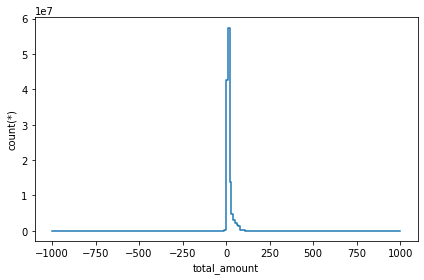

In [7]:
# plot with vaex to find outliers of total_amount
taxi.plot1d(taxi.total_amount, shape=200, limits=[-1000, 1000])

In [8]:
# From the plot, keep 0 to 1000 as "not outlier" range
taxi=taxi[(taxi.total_amount>0)&(taxi.total_amount<1000)]

After "total_amount" excludes the outliers, the "fare amount" is to be cleansed.

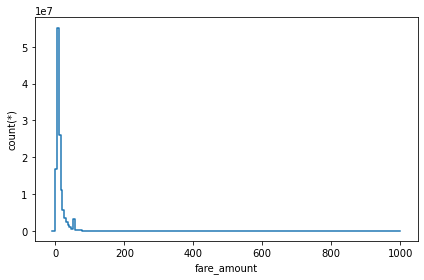

In [9]:
# Cleanse "fare_amount" outliers
# plot with vaex to find outliers of fare_amount
taxi.plot1d(taxi.fare_amount, shape=200, limits=[-10, 1000])

In [10]:

# From the plot, keep 0 to 1000 as "not outlier" range

taxi=taxi[(taxi.fare_amount>0)&(taxi.fare_amount<1000)]

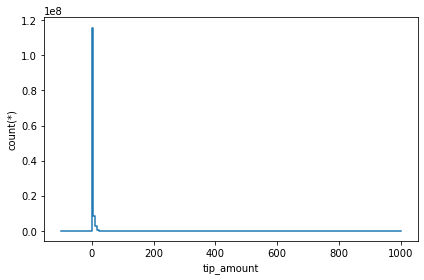

In [11]:
# Clean "tip_amount" outliers
# plot with vaex to find outliers of tip_amount
taxi.plot1d(taxi.tip_amount, shape=200, limits=[-100, 1000])

# From the plot, keep 0 to 1000 as "not outlier" range

taxi=taxi[(taxi.tip_amount>0)&(taxi.tip_amount<1000)]

In [12]:
taxi=taxi.copy()

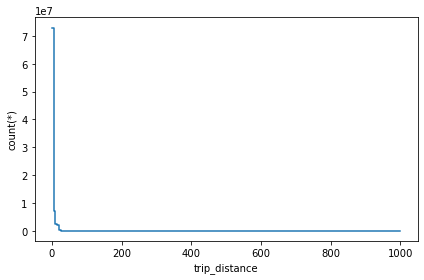

In [13]:
# "trip_distance" column to cleanse up


# plot with vaex to find outliers 
taxi.plot1d(taxi.trip_distance, shape=200, limits=[0, 1000])

# From the plot, keep "not outlier" range

taxi=taxi[(taxi.trip_distance>0)&(taxi.trip_distance<1000)]

In [14]:
# Join the "taxi" DF with "drop_date" DF
# Convert taxi vaex dataframe to pandas by keeping only relevant attributes
# First copy a "taxi" df
taxi_new=taxi.copy()

In [15]:
# Save taxi_new to pd df
taxi_pd=taxi_new.to_pandas_df()

In [16]:
# Extract year, month,weekday name of the 'dropdate'
taxi_pd['year'] = taxi_pd['tpep_pickup_datetime'].dt.year
taxi_pd['month'] = taxi_pd['tpep_pickup_datetime'].dt.month
taxi_pd['weekday'] = taxi_pd['tpep_pickup_datetime'].dt.dayofweek
# Extract the hour of the 'dropdate'
taxi_pd['hour'] = taxi_pd['tpep_pickup_datetime'].dt.hour


In [17]:
# Convert "trip duration" to min
taxi_pd['duration_min']  = taxi_pd['trip_duration'] / pd.Timedelta(minutes=1)

In [18]:
# Convert pd df to vaex df
taxi_up = vaex.from_pandas(df=taxi_pd, copy_index=False)

In [19]:
taxi_up.tail(1)

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min
0,2,2020-12-31 23:12:48.000000000,2020-12-31 23:24:51.000000000,nan,2.35,18,235,0,17.09,2.75,20.64,0 days +0:12:03,2020,12,3,23,12.05


In [20]:
taxi_up2=taxi_up.copy()

In [21]:
# Find the wrong year values
taxi_up2=taxi_up2[(taxi_up2['year']>=2018)]

In [22]:
taxi_up2=taxi_up2[(taxi_up2['year']<=2020)]

In [23]:
taxi_up2.tail(1)

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min
0,2,2020-12-31 23:12:48.000000000,2020-12-31 23:24:51.000000000,nan,2.35,18,235,0,17.09,2.75,20.64,0 days +0:12:03,2020,12,3,23,12.05


In [24]:
taxi_up3=taxi_up2.copy()

In [25]:
taxi_up3.tail(1)

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min
0,2,2020-12-31 23:12:48.000000000,2020-12-31 23:24:51.000000000,nan,2.35,18,235,0,17.09,2.75,20.64,0 days +0:12:03,2020,12,3,23,12.05


In [26]:
# only keep trip duration >0 min and <60*24 min

taxi_up4=taxi_up3[(taxi_up3['duration_min']>0)&(taxi_up3['duration_min']<60*24)]

In [27]:
taxi_up4.tail(1)

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min
0,2,2020-12-31 23:12:48.000000000,2020-12-31 23:24:51.000000000,nan,2.35,18,235,0,17.09,2.75,20.64,0 days +0:12:03,2020,12,3,23,12.05


In [28]:
# Add a column to calculate the "fare_amount per mile" in order to filter out the outliers
taxi_up4['fare_mile']=taxi_up4['fare_amount']/taxi_up4['trip_distance']

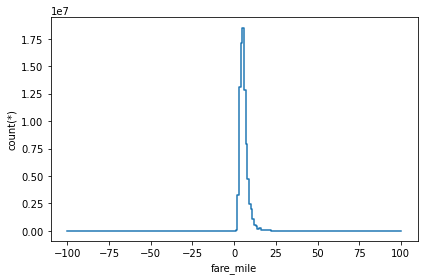

In [29]:
# Plot the "fare_mile"
taxi_up4.plot1d(taxi_up4.fare_mile, shape=200, limits=[-100, 100])

Filter out to keep "fare_amount" between 0 and 10 (with reference to standard [fare price]("https://www.nyc.gov/site/tlc/passengers/taxi-fare.page")


In [30]:
taxi_up5=taxi_up4[(taxi_up4['fare_mile']>0)&(taxi_up4['fare_mile']<10)]

In [31]:
# Exclude "na" "passenger_count" - as only "passenger_count" has "na", can dropna in the dataframe
taxi_up6=taxi_up5.dropna()

In [32]:
# Exclude the outliers in the "passenger_count" - maximum is 6
taxi_up7=taxi_up6[taxi_up6['passenger_count']<=6]

In [33]:
taxi_up7.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min,fare_mile
data_type,int64,datetime64[ns],datetime64[ns],float64,float64,int64,int64,int64,float64,float64,float64,timedelta64[ns],int64,int64,int64,int64,float64,float64
count,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513,79473513
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,1.6097355354103953,1970-01-01T00:01:19.469442844,1970-01-01T00:02:47.793596593,1.5615417050961369,3.110277389274291,164.54482880352853,162.72637788139554,1.0000439769159317,13.183621985100876,2.8928626020293313,18.076564788728263,88324153748 nanoseconds,2018.4030253576434,5.924481355190628,2.9552424214593356,13.96652100933301,16.946192516576616,5.463332858660661
std,0.509891,25010793449633328.0,25010754072668872.0,1.215507,3.779337,65.918385,70.289579,0.009196,10.947691,2.639747,14.316962,3513097830548.308105,0.802259,3.622505,1.935087,6.106334,58.551631,1.638945
min,1,2018-01-01T00:01:11.432929280,2018-01-01T00:03:28.871882752,0.0,0.02,1,1,1,0.01,0.01,0.36,1000000000 nanoseconds,2018,1,0,0,0.016667,0.000193
max,4,2021-01-01T00:00:10.863509504,2021-01-01T23:08:18.869313536,6.0,932.9,265,265,4,820.5,945.97,996.1,86398996578304 nanoseconds,2020,12,6,23,1439.983333,9.999091


In [34]:
taxi_up7.tail(1)

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min,fare_mile
0,2,2020-12-31 23:54:57.000000000,2020-12-31 23:57:39.000000000,1,0.59,238,239,1,4.5,2.08,10.38,0 days +0:02:42,2020,12,3,23,2.7,7.62712


In [35]:
# rename the dataset to "taxi_all"
taxi_all=taxi_up7

# Data wrangling
## Import ArcMap file of the taxi zones

In [36]:
from simpledbf import Dbf5

In [37]:
import geopandas as gpd
zone=gpd.read_file('/Users/silviawu/Downloads/YellowTaxi/taxi_zones/taxi_zones.dbf')

In [38]:
zone.geometry.name

'geometry'

In [39]:
# Rename the geometry to "borders" 

zone=zone.rename(columns={'geometry':'borders'}).set_geometry('borders')

In [40]:
zone.geometry.name

'borders'

<AxesSubplot:>

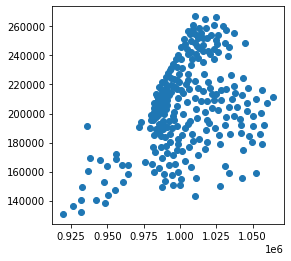

In [41]:
# Create centroilds and make it geometry
zone['centroid_column']=zone.centroid
zone=zone.set_geometry('centroid_column')
zone.plot()

In [42]:
zone.head(1)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,borders,centroid_column
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.821 191376.750)


In [43]:
# Drop borders 
zone_updated=zone.drop(['borders'],axis=1)
# Save zone df to geojson
zone_updated.to_file('/Users/silviawu/Downloads/YellowTaxi/zone.json')

## Hypothesis: people take more trips in the winter than in the summer?
### H Test: check the # of trips of different months in the year

In [44]:
# Get the average demand per month
demand_month=taxi_all.groupby(by='month').agg({'row_nb':'count'})

In [45]:
# Convert Vaex DF to Pandas DF
demand_month_pd=demand_month.to_pandas_df()

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline  

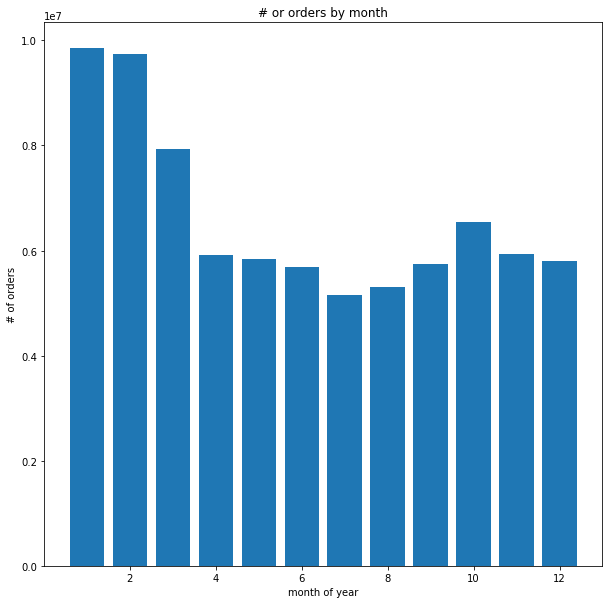

In [47]:
x = demand_month_pd['month']
y = demand_month_pd['row_nb']
# Figure Size
fig = plt.figure(figsize =(10, 10))
 
# Horizontal Bar Plot
plt.bar(x[0:24], y[0:24])
plt.title('# or orders by month')
plt.xlabel('month of year')
plt.ylabel('# of orders')

# Show Plot
plt.show()

From the chart, it is noted that the # of trips on Jan and Feb and March are higher in other months.

## Hypothesis: people have more demand in the evening?
### H Test: check the average demand by the hour of the day

In [48]:
# Get the average demand per hour
demand_hour=taxi_all.groupby(by='hour').agg({'row_nb':'count'})

In [49]:
# Convert Vaex DF to Pandas DF
demand_hour_pd=demand_hour.to_pandas_df()

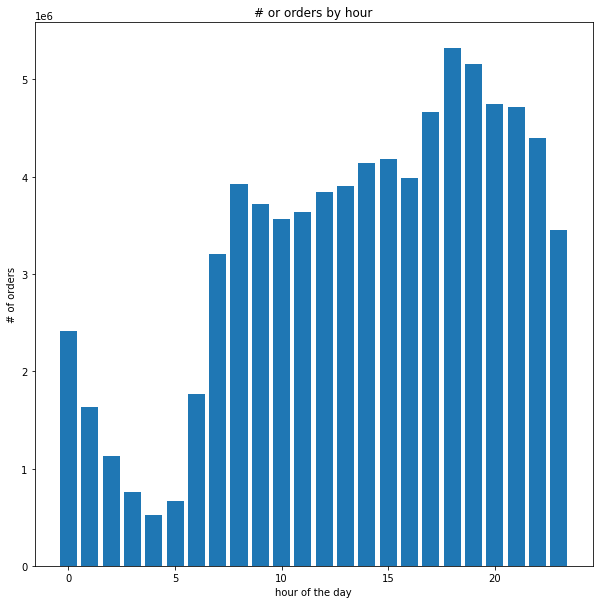

In [50]:
x = demand_hour_pd['hour']
y = demand_hour_pd['row_nb']
# Figure Size
fig = plt.figure(figsize =(10, 10))
 
# Horizontal Bar Plot
plt.bar(x[0:24], y[0:24])
plt.title('# or orders by hour')
plt.xlabel('hour of the day')
plt.ylabel('# of orders')

# Show Plot
plt.show()

From the chart, it is noted that the demand is highest at 18h, and from 18h to 24h, the demand is higher than during the day. But between 0h and 6h, the demand is much lower than in the day.

## Hypothesis: the demand in the evening has different patterns between workday and weekend
### H - Test: check the average demand by hour of each day of the week

In [51]:
# Get the average demand per hour by the day of the week
demand_hour_weekday=taxi_all.groupby(['hour','weekday'],agg=vaex.agg.count('VendorID'))

In [52]:
# Covert Vaex DF to Pandas DF
demand_hour_weekday_pd=demand_hour_weekday.to_pandas_df()

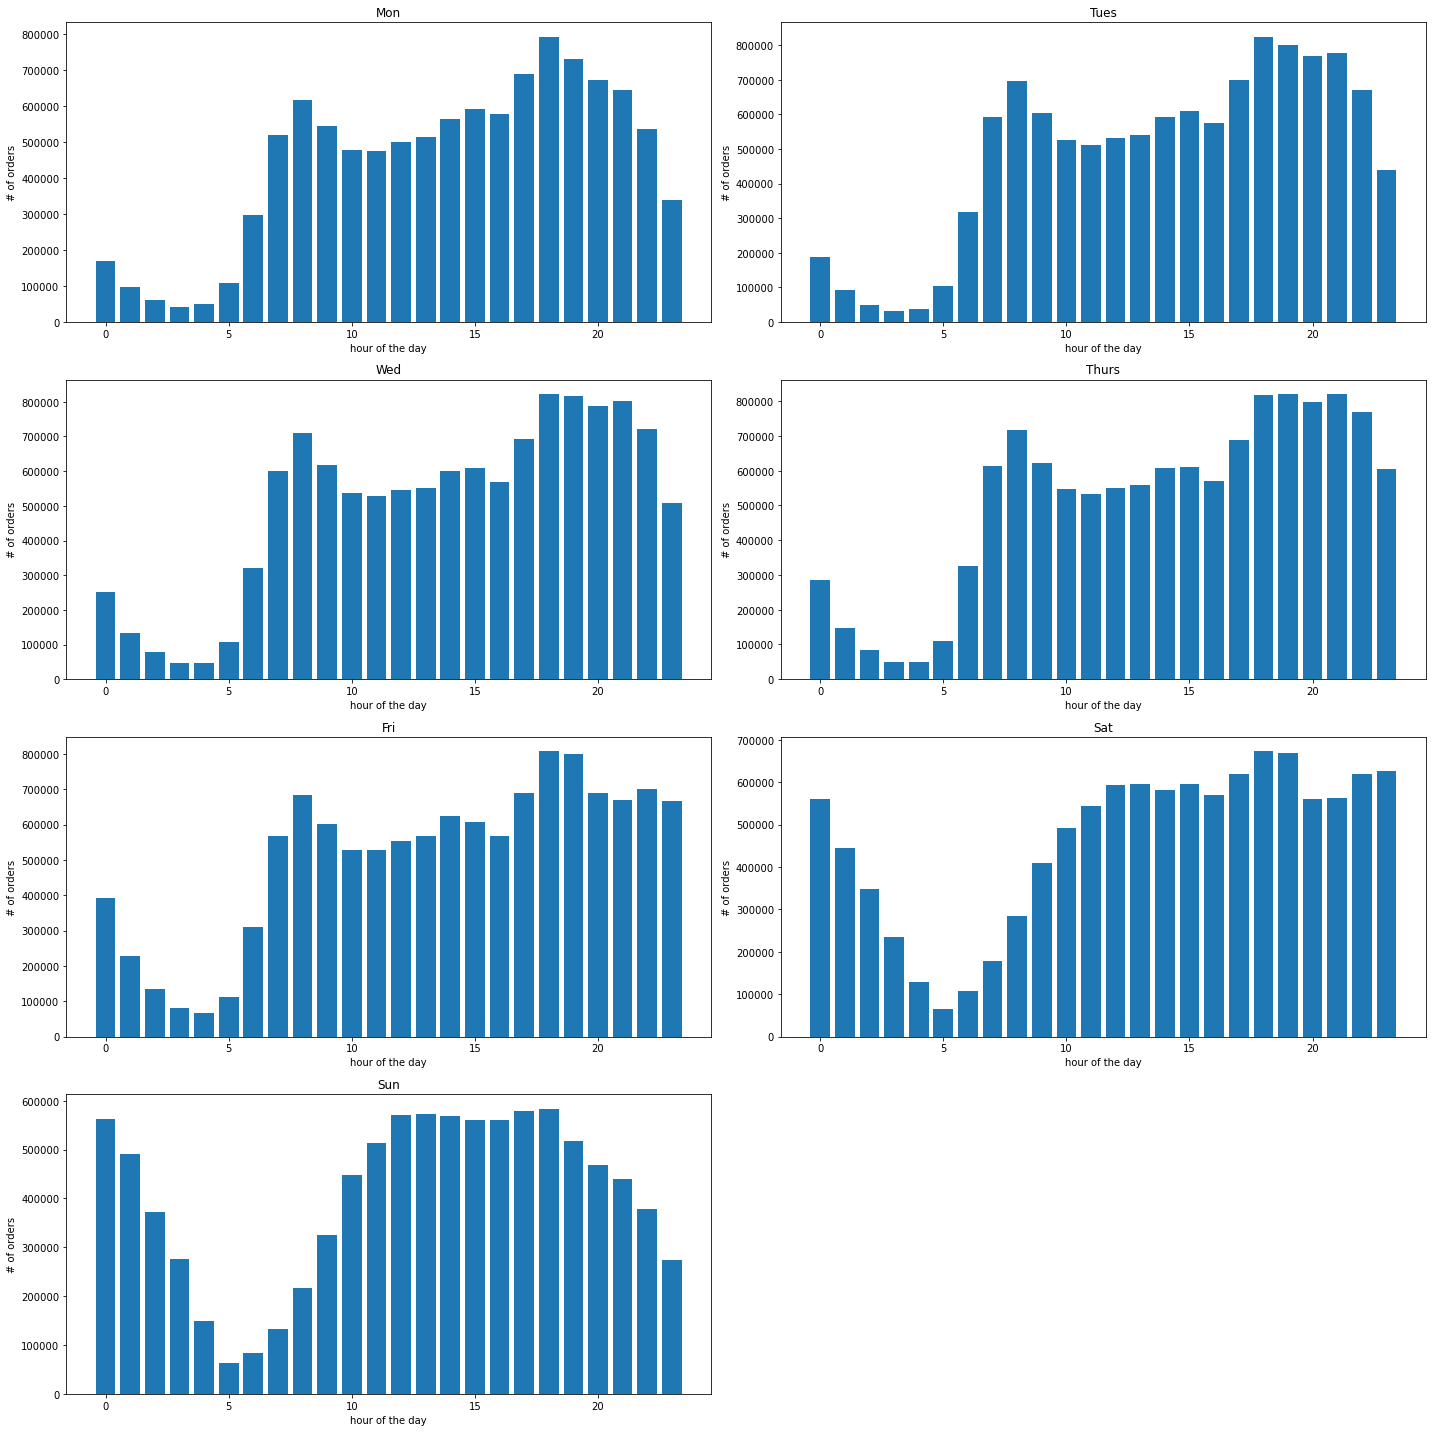

In [53]:
# Make the graph 20 inches by 20 inches
plt.figure(figsize=(20,20))
# Create the weekday name
weekday_names = [ "Mon", "Tues","Wed","Thurs","Fri","Sat","Sun"]# plot numbering starts at 1, not 0
plot_number = 1
for weekday, selection in demand_hour_weekday_pd.groupby("weekday"):
    # Inside of an image that's a 2x4 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 2, plot_number)
    plt.bar(selection['hour'][0:24],selection['VendorID_count'][0:24])
    plt.title('demand of the hour by weekday')
    plt.xlabel('hour of the day')
    plt.ylabel('# of orders')
   
    ax.set_title(weekday_names[weekday])

    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

From the chart, it is noted that:
1. From Sun to Thurs, the demand between 18h and 22h are the higest of the day, but after 23h, the demand drops until 6h.
2. By comparison, on Fri and Sat, the demand in the evening is quite high until 0h.

## Hypothesis : people pay more tips in the weekend?             
### H - Test : check the average tip % of different days of the week

In [54]:
# Add a fied to get the % of tips of the "total_amount"
taxi_all['tip%']=taxi_all['tip_amount']/taxi_all['total_amount']

In [55]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt

In [56]:
# Exclude the "cash customers" because their tip isn't recorded
taxi_w_o_cash=taxi_all[taxi_all['payment_type']!=2]

In [57]:
# Get the average tip% by "weekday"
tip_day=taxi_w_o_cash.groupby(by='weekday').agg({'tip%': 'mean'})

In [58]:
# Convert Vaex DF to Pandas DF
tip_day_pd=tip_day.to_pandas_df()
tip_day_pd['tip%']=tip_day_pd['tip%']*100

In [59]:
tip_day_pd

,weekday,tip%
0,0,16.020627
1,1,16.002581
2,2,15.995088
3,3,15.969624
4,4,15.908003
5,5,15.944727
6,6,15.956866


In [60]:
tip_avg=tip_day_pd['tip%'].mean()

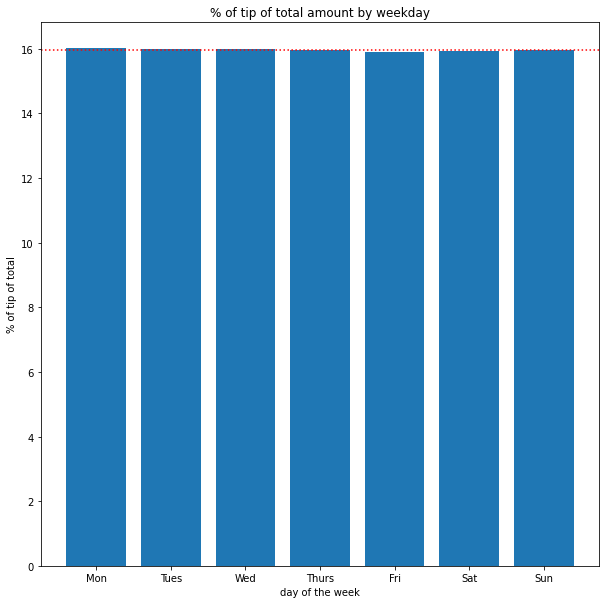

In [61]:
weekday_names = [ "Mon", "Tues","Wed","Thurs","Fri","Sat","Sun"]
x = weekday_names
y = tip_day_pd['tip%']
# Figure Size
fig = plt.figure(figsize =(10, 10))
 
# Horizontal Bar Plot
plt.bar(x[0:24], y[0:24])
plt.title('% of tip of total amount by weekday')
plt.xlabel('day of the week')
plt.ylabel('% of tip of total')

# Reference line
plt.axhline(tip_avg, color='red', ls='dotted',label='Average tip%')
# Show Plot
plt.show()

The chart shows no strong evidence that people pay more tip at weekend.

## Hypothesis 1: people pay more tips in the evening?
### H1 - Test 1: check the average tip % by hour as aggregated data

In [62]:
taxi_all.head(1)

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,trip_duration,year,month,weekday,hour,duration_min,fare_mile,tip%
0,1,2018-01-01 00:08:26.000000000,2018-01-01 00:14:21.000000000,2,0.8,262,141,1,6,1,8.3,0 days +0:05:55,2018,1,0,0,5.91667,7.5,0.120482


In [63]:
demand_hour_weekday_pd

,hour,weekday,VendorID_count
0,0,0,170286
1,0,1,187222
2,0,2,250127
3,0,3,286357
4,0,4,391776
...,...,...,...
163,23,2,508011
164,23,3,603750
165,23,4,666469
166,23,5,627249


In [64]:
# Get the average tip% by "hour"
tip_hour=taxi_w_o_cash.groupby(by='hour').agg({'tip%': 'mean'})

In [65]:
tip_hour_pd=tip_hour.to_pandas_df()

In [66]:
tip_hour_pd['tip%']=tip_hour_pd['tip%']*100

In [67]:
# Get the average tip% of all the hours
tip_avg=tip_hour_pd['tip%'].mean()

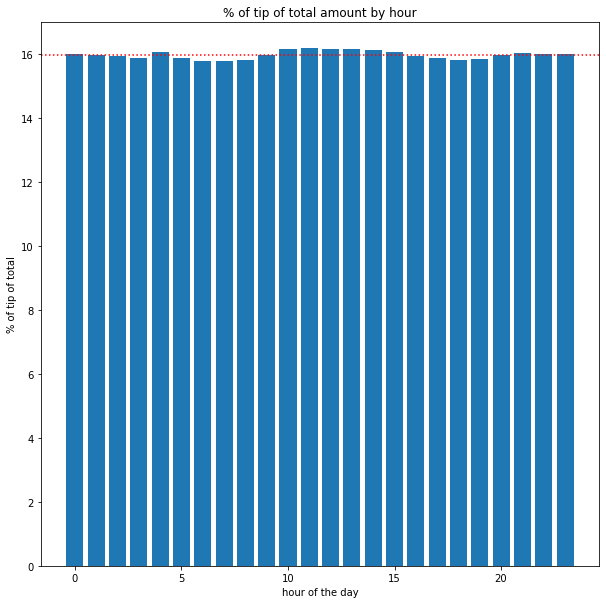

In [68]:
x = tip_hour_pd['hour']
y = tip_hour_pd['tip%']
# Figure Size
fig = plt.figure(figsize =(10, 10))
 
# Horizontal Bar Plot
plt.bar(x[0:24], y[0:24])
plt.title('% of tip of total amount by hour')
plt.xlabel('hour of the day')
plt.ylabel('% of tip of total')

# Reference line
plt.axhline(tip_avg, color='red', ls='dotted',label='Average tip%')
# Show Plot
plt.show()

From the chart above, there is no obvious evidence that people pay more tips in the evening. So, to further check the analysis, the data goes to the "day of week" to check if people pay more tips by hour and by day of week
### H1 - Test 2 People pay more tips in the evening of weekday?

In [69]:
tip_hour_weekday=taxi_w_o_cash.groupby(['hour','weekday'],agg=vaex.agg.mean('tip%'))

In [70]:
tip_hour_weekday_pd=tip_hour_weekday.to_pandas_df()

In [71]:
tip_hour_weekday_pd['tip%_mean']=tip_hour_weekday_pd['tip%_mean']*100

In [72]:
tip_hour_weekday_pd

,hour,weekday,tip%_mean
0,0,0,16.062668
1,0,1,16.304775
2,0,2,16.269808
3,0,3,16.234062
4,0,4,16.098776
...,...,...,...
163,23,2,16.112431
164,23,3,16.009657
165,23,4,15.836154
166,23,5,15.737317


In [73]:
len(tip_hour_weekday_pd.groupby("weekday"))

7

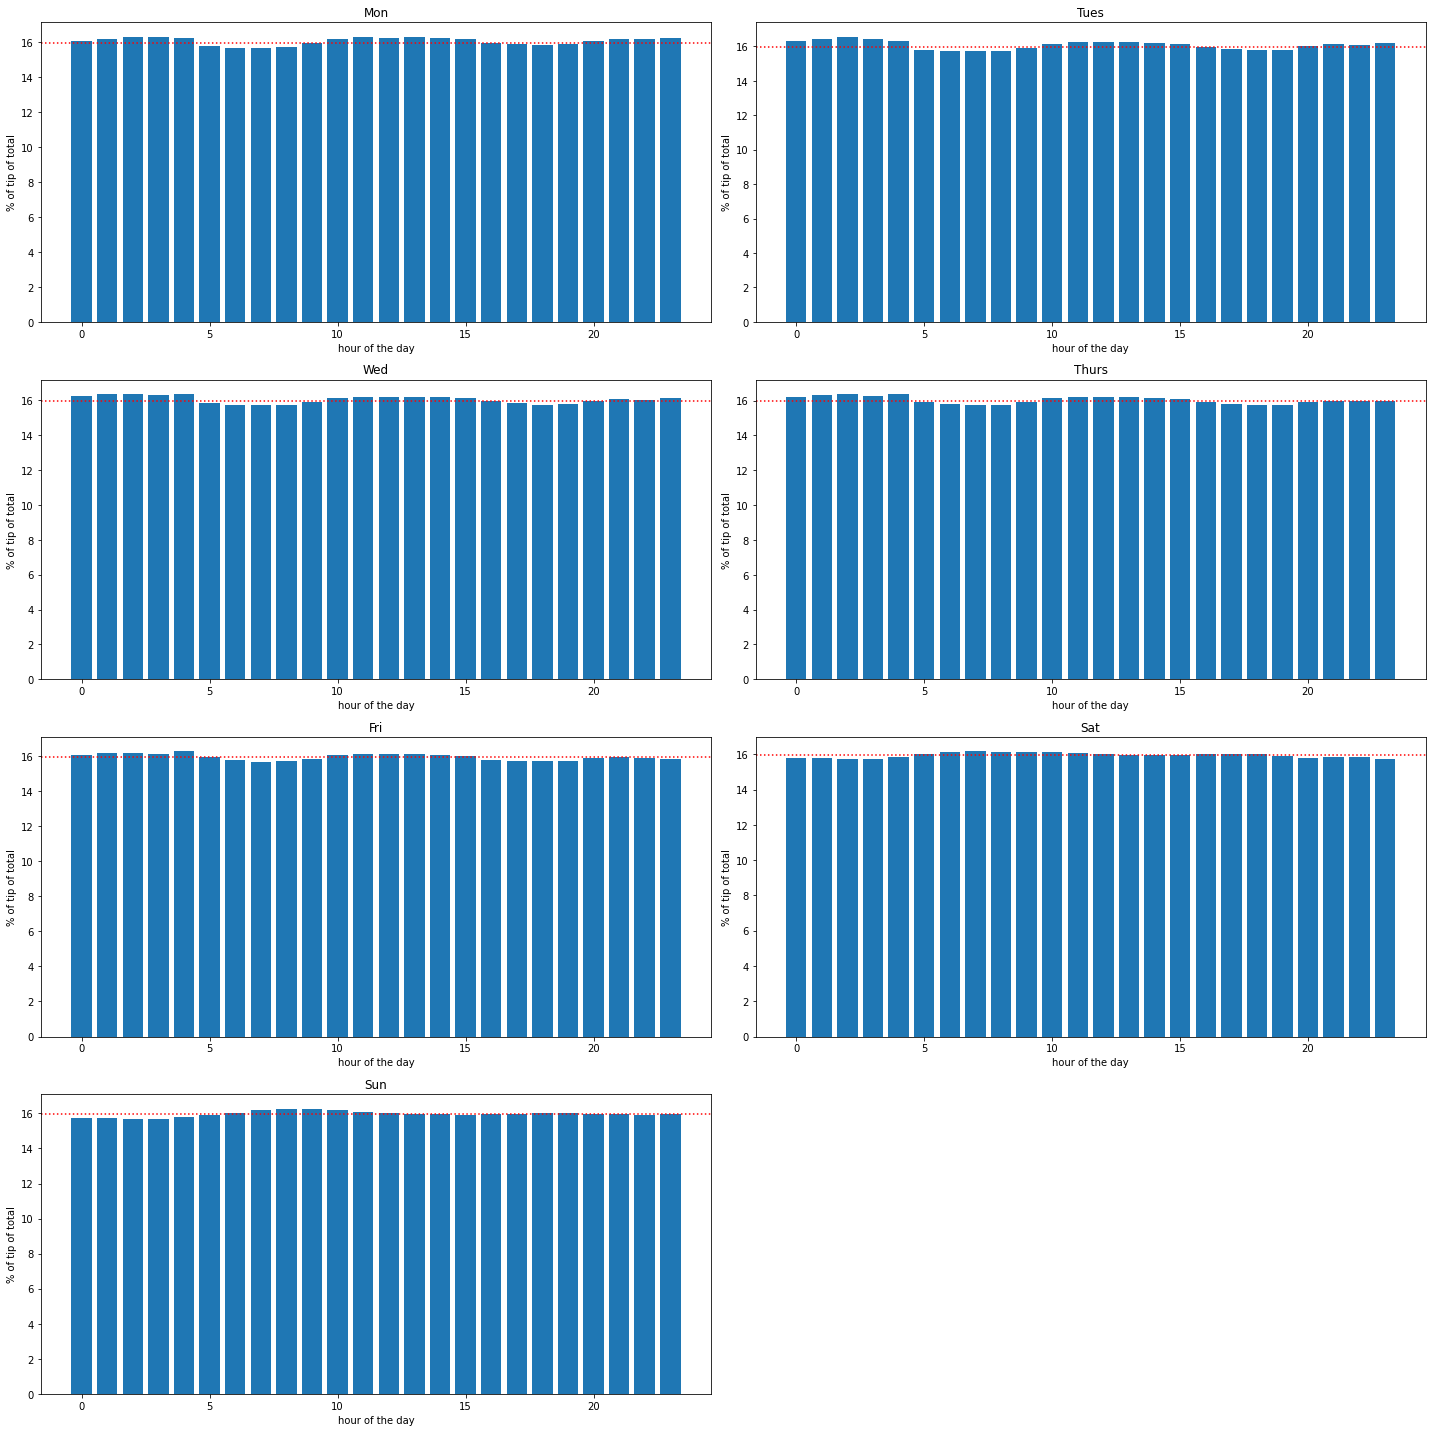

In [74]:
# Make the graph 20 inches by 20 inches
plt.figure(figsize=(20,20))
# Create the weekday name
weekday_names = [ "Mon", "Tues","Wed","Thurs","Fri","Sat","Sun"]
# plot numbering starts at 1, not 0
plot_number = 1
for weekday, selection in tip_hour_weekday_pd.groupby("weekday"):
    # Inside of an image that's a 2x4 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 2, plot_number)
    plt.bar(selection['hour'][0:24],selection['tip%_mean'][0:24])
    plt.title('% of tip of total amount by hour')
    plt.xlabel('hour of the day')
    plt.ylabel('% of tip of total')
   
    ax.set_title(weekday_names[weekday])
    # Reference line
    plt.axhline(tip_avg, color='red', ls='dotted',label='Average tip%')
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

From the charts above, it is found that:
1. people pay a tip slightly higher than average after 0 h;
2. but on Fri and Sat, people don't pay more after 0h for the tip.

## Export data for further visualization

In [75]:
# Aggregate the demand by year_month_weekday_hour
demand_year_month_weekday_hour=taxi_all.groupby(['year','month','weekday','hour'],agg=vaex.agg.count('VendorID'))

# Save file to csv
demand_year_month_weekday_hour.export_csv('demand_year_month_weekday_hour.csv')

In [76]:
# Aggregate the spend by year_month_weekday_hour
spend_year_month_weekday_hour=taxi_all.groupby(['year','month','weekday','hour'],agg=vaex.agg.sum('total_amount'))

# Save file to csv
spend_year_month_weekday_hour.export_csv('spend_year_month_weekday_hour.csv')

In [77]:
# Aggregate the tip% by year_month_weekday_hour
tip_year_month_weekday_hour=taxi_all.groupby(['year','month','weekday','hour'],agg=vaex.agg.mean('tip%'))

# Save file to csv
tip_year_month_weekday_hour.export_csv('tip_year_month_weekday_hour.csv')

In [78]:
# Aggregate the tip% by year_month_weekday_hour_passenger#
tip_year_month_weekday_hour_passenger=taxi_all.groupby(['year','month','weekday','hour','passenger_count'],agg=vaex.agg.mean('tip%'))

# Save file to csv
tip_year_month_weekday_hour_passenger.export_csv('tip_year_month_weekday_hour_passenger.csv')

In [79]:
# Aggregate the trip # by year_month_weekday_hour_passenger#
trip_year_month_weekday_hour_passenger=taxi_all.groupby(['year','month','weekday','hour','passenger_count'],agg=vaex.agg.count('VendorID'))

# Save file to csv
trip_year_month_weekday_hour_passenger.export_csv('trip_year_month_weekday_hour_passenger.csv')

In [80]:
# Aggregate the demand by year_month_weekday_location
demand_year_month_weekday_location=taxi_all.groupby(['year','month','weekday','DOLocationID'],agg=vaex.agg.count('VendorID'))

# Save file to csv
demand_year_month_weekday_location.export_csv('demand_year_month_weekday_location.csv')

## Other assumptions to visualize directly on Dashboard
- People start trips in certain areas in the morning and end trips in certain areas.
- People tend to take shorter trips (distance-wise) in the day than in the evening.
- People tend to be more generous with tips with low total-cost trips
- In 2020, people had more trips at the beginning of Covid breakout but later the trip # decreased.
- The pattern of the popular areas above changed after Covid breakout.

# Predict the tip amount of a trip (from Feb and August 2018 Data)

In [81]:
# Select 2018 Feb and Aug data 
taxi_2018_2_8=taxi_all[(taxi_all['year']==2018)&((taxi_all['month']==2)|(taxi_all['month']==8))]
# Save to taxi_all DF to parquet to prepare for the linear aggression
taxi_2018_2_8.export('taxi_all.parquet')

In [83]:
import pandas as pd
taxi_pd=pd.read_parquet("/Users/silviawu/Downloads/YellowTaxi/Yellow Taxi Notebook and data output/taxi_all.parquet")

In [84]:
# Split the df into train and test data
from sklearn.model_selection import train_test_split
train,test=train_test_split(taxi_pd,test_size=0.2)

In [85]:
# Check the correlation of the attributes 

# Select columns for the correlation 
train=train.drop(['VendorID'],axis=1)

In [86]:
# Get the correlation of the attributes with absolute correlation value
corrmat=train.corr()
sorted_corrs=corrmat['tip_amount'].abs().sort_values()

<AxesSubplot:>

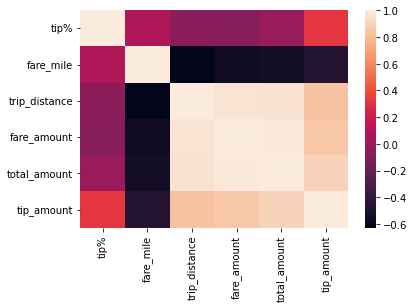

In [87]:
# Select strong correlation
# Define strong correlation as >0.3
strong_corrs=sorted_corrs[sorted_corrs>0.3]

# Visualize the correlation
import seaborn as sns

corrmat=train[strong_corrs.index].corr()
sns.heatmap(corrmat)

From the correlation of the attributes, the attributes with high correlation will be dropped: fare_amount,total_amount,fare_mile,tip%

In [88]:
columns_to_drop=['fare_amount','total_amount','fare_mile','tip%']
train_after_drop=train.drop(columns_to_drop,axis=1)

In [89]:
train_clean=train_after_drop.copy()

In [90]:
# Convert month, weekday and hour to categorical type
categorical_columns=['month','weekday','hour']
train_clean[categorical_columns].astype('category')

,month,weekday,hour
1309427,2,2,16
4546379,2,5,12
8130486,8,4,22
7752130,8,2,19
4646152,2,5,21
...,...,...,...
6565990,8,2,7
2032129,2,5,23
8319832,8,6,12
2059687,2,6,2


In [91]:
train_to_convert_to_dummy=train_clean.copy()

In [92]:
# Add prefix to month and weekday and hour
train_to_convert_to_dummy['month']='m'+train_to_convert_to_dummy['month'].astype(str)
train_to_convert_to_dummy['weekday']='w'+train_to_convert_to_dummy['weekday'].astype(str)
train_to_convert_to_dummy['hour']='h'+train_to_convert_to_dummy['hour'].astype(str)

In [93]:
train_to_convert_to_dummy.head(1)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,trip_duration,year,month,weekday,hour,duration_min
1309427,2018-02-07 16:55:59,2018-02-07 17:00:57,1.0,0.78,170,234,1,2.19,0 days 00:04:58,2018,m2,w2,h16,4.966667


In [94]:
train_v=train_to_convert_to_dummy.copy()

In [95]:
train_v.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,trip_duration,year,month,weekday,hour,duration_min
1309427,2018-02-07 16:55:59,2018-02-07 17:00:57,1.0,0.78,170,234,1,2.19,0 days 00:04:58,2018,m2,w2,h16,4.966667
4546379,2018-02-24 12:24:40,2018-02-24 12:33:05,2.0,0.80,113,234,1,1.00,0 days 00:08:25,2018,m2,w5,h12,8.416667
8130486,2018-08-17 22:47:51,2018-08-17 23:09:23,1.0,3.49,211,163,1,4.20,0 days 00:21:32,2018,m8,w4,h22,21.533333
7752130,2018-08-15 19:52:56,2018-08-15 20:00:38,1.0,2.70,87,4,1,2.95,0 days 00:07:42,2018,m8,w2,h19,7.700000
4646152,2018-02-24 21:35:22,2018-02-24 22:11:03,2.0,5.70,79,238,1,3.95,0 days 00:35:41,2018,m2,w5,h21,35.683333


In [96]:
# Convert categorical columns to dummy columns and delete it from original data frame
for col in categorical_columns:
    col_dummies=pd.get_dummies(train_v[col])
    train_v=pd.concat([train_v,col_dummies],axis=1)
    del train_v[col]
    

In [97]:
train_f=train_v.copy()

In [98]:
# convert Test DF to the same format as train DF
test_to_convert=test.copy()

In [99]:
# Convert month, weekday and hour to categorical type
categorical_columns=['month','weekday','hour']
test_to_convert[categorical_columns].astype('category')

,month,weekday,hour
8247272,8,5,20
760864,2,6,18
965409,2,0,20
5438568,8,2,2
9488137,8,0,16
...,...,...,...
3904404,2,2,8
7887830,8,3,15
1645872,2,4,7
2656131,2,2,11


In [100]:
# Add prefix to month and weekday and hour
test_to_convert['month']='m'+test_to_convert['month'].astype(str)
test_to_convert['weekday']='w'+test_to_convert['weekday'].astype(str)
test_to_convert['hour']='h'+test_to_convert['hour'].astype(str)

In [101]:
# Convert categorical columns to dummy columns and delete it from original data frame
for col in categorical_columns:
    col_dummies=pd.get_dummies(test_to_convert[col])
    test_to_convert=pd.concat([test_to_convert,col_dummies],axis=1)
    del test_to_convert[col]

In [102]:
test_v=test_to_convert.copy()
test_v.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,h21,h22,h23,h3,h4,h5,h6,h7,h8,h9
8247272,2,2018-08-18 20:41:30,2018-08-18 20:47:13,6.0,1.56,237,236,1,7.0,1.00,...,0,0,0,0,0,0,0,0,0,0
760864,2,2018-02-04 18:09:43,2018-02-04 18:16:13,4.0,0.90,166,166,1,6.0,1.36,...,0,0,0,0,0,0,0,0,0,0
965409,1,2018-02-05 20:30:34,2018-02-05 20:37:05,1.0,1.10,170,48,1,6.5,1.00,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# Drop columns from test_v for columns that have been dropped from train DF
columns_to_drop=['fare_amount','total_amount','fare_mile','tip%','VendorID']
test_f=test_v.drop(columns_to_drop,axis=1)

In [104]:
# Select attributes for the linear regression
attributes_to_drop=['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID','payment_type','trip_duration','year']

In [105]:
# Drop the columns above from train data
train_final=train_f.drop(attributes_to_drop,axis=1)

In [106]:
# Drop the columns above from test data
test_final=test_f.drop(attributes_to_drop,axis=1)

In [107]:
# Import sklearn LR
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

In [108]:
# Specify the variables and target
variables=['passenger_count', 'trip_distance', 'duration_min', 'm2',
       'm8', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'h0', 'h1', 'h10',
       'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h2',
       'h20', 'h21', 'h22', 'h23', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9']
target=['tip_amount']

In [109]:
# fit the train data
lr.fit(train_final[variables],train_final[target])

LinearRegression()

In [110]:
# Predict train and test data with the LR
train_predictions=lr.predict(train_final[variables])
test_predictions=lr.predict(test_final[variables])

In [111]:
# Import numpy and mse
import numpy as np
from sklearn.metrics import mean_squared_error
# Calculate the RMSE of train and test data
train_rmse=np.sqrt(mean_squared_error(train_predictions,train_final[target]))
test_rmse=np.sqrt(mean_squared_error(test_predictions,test_final[target]))
                     

In [112]:
print(train_rmse)
print(test_rmse)

1.4441931340608005
1.4435748767358079


In [113]:
lr.intercept_

array([3.84433691e+08])

In [114]:
lr.coef_

array([[ 5.51637941e-03,  5.64975001e-01,  3.92771853e-04,
        -7.93234264e+06, -7.93234264e+06, -2.26013678e+08,
        -2.26013678e+08, -2.26013678e+08, -2.26013678e+08,
        -2.26013678e+08, -2.26013679e+08, -2.26013679e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08,
        -1.50487669e+08, -1.50487669e+08, -1.50487669e+08]])

As it is very hard to see the coefficients as they are, the variables are to be aggregated to test
## Test with aggregated weekday and hour

In [115]:
# Convert Weekday to "weekday" and "weekend" 
train_agg=train_final.copy()

In [116]:
train_agg['In_week']=train_agg['w0']+train_agg['w1']+train_agg['w2']+train_agg['w3']+train_agg['w4']
train_agg['At_weekend']=train_agg['w5']+train_agg['w6']

In [117]:
# Convert hour to "Morning" "Afternoon" "Evening" "Night"
train_agg['Morning']=train_agg['h6']+train_agg['h7']+train_agg['h8']+train_agg['h9']+train_agg['h10']+train_agg['h11']
train_agg['Afternoon']=train_agg['h12']+train_agg['h13']+train_agg['h14']+train_agg['h15']+train_agg['h16']+train_agg['h17']
train_agg['Evening']=train_agg['h18']+train_agg['h19']+train_agg['h20']+train_agg['h21']+train_agg['h22']+train_agg['h23']
train_agg['Night']=train_agg['h0']+train_agg['h1']+train_agg['h2']+train_agg['h3']+train_agg['h4']+train_agg['h5']

In [118]:
train_agg.head()

,passenger_count,trip_distance,tip_amount,duration_min,m2,m8,w0,w1,w2,w3,...,h6,h7,h8,h9,In_week,At_weekend,Morning,Afternoon,Evening,Night
1309427,1.0,0.78,2.19,4.966667,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4546379,2.0,0.80,1.00,8.416667,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8130486,1.0,3.49,4.20,21.533333,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
7752130,1.0,2.70,2.95,7.700000,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4646152,2.0,5.70,3.95,35.683333,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [119]:
# Convert Weekday to "weekday" and "weekend" for test data and "hour" to "Morning" "Afternoon" "Evening" "Night"
# Exclude duration in min
test_agg=test_final.copy()

test_agg['In_week']=test_agg['w0']+test_agg['w1']+test_agg['w2']+test_agg['w3']+test_agg['w4']
test_agg['At_weekend']=test_agg['w5']+test_agg['w6']

test_agg['Morning']=test_agg['h6']+test_agg['h7']+test_agg['h8']+test_agg['h9']+test_agg['h10']+test_agg['h11']
test_agg['Afternoon']=test_agg['h12']+test_agg['h13']+test_agg['h14']+test_agg['h15']+test_agg['h16']+test_agg['h17']
test_agg['Evening']=test_agg['h18']+test_agg['h19']+test_agg['h20']+test_agg['h21']+test_agg['h22']+test_agg['h23']
test_agg['Night']=test_agg['h0']+test_agg['h1']+test_agg['h2']+test_agg['h3']+test_agg['h4']+test_agg['h5']


In [120]:
train_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8138074 entries, 1309427 to 6321541
Data columns (total 43 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  float64
 1   trip_distance    float64
 2   tip_amount       float64
 3   duration_min     float64
 4   m2               uint8  
 5   m8               uint8  
 6   w0               uint8  
 7   w1               uint8  
 8   w2               uint8  
 9   w3               uint8  
 10  w4               uint8  
 11  w5               uint8  
 12  w6               uint8  
 13  h0               uint8  
 14  h1               uint8  
 15  h10              uint8  
 16  h11              uint8  
 17  h12              uint8  
 18  h13              uint8  
 19  h14              uint8  
 20  h15              uint8  
 21  h16              uint8  
 22  h17              uint8  
 23  h18              uint8  
 24  h19              uint8  
 25  h2               uint8  
 26  h20              uint8  
 27  h21   

In [121]:
# Select columns to keep
columns_to_keep=['passenger_count','trip_distance','tip_amount','duration_min','In_week','At_weekend','Morning','Afternoon','Evening','Night','m2','m8']

In [122]:
# Keep only columns to keep
train_agg_final=train_agg[columns_to_keep]

test_agg_final=test_agg[columns_to_keep]

# Define variables
variables2=['passenger_count','trip_distance','In_week','At_weekend','Morning','Afternoon','Evening','Night','m2','m8']
target2=['tip_amount']

lr2=LinearRegression()
lr2.fit(train_agg_final[variables2],train_agg_final[target2])

# Predict train and test data with LR2
train_predictions_2=lr2.predict(train_agg_final[variables2])
test_predictions_2=lr2.predict(test_agg_final[variables2])

# Calculate RMSE
train_2_rmse=np.sqrt(mean_squared_error(train_predictions_2,train_agg_final[target]))
test_2_rmse=np.sqrt(mean_squared_error(test_predictions_2,test_agg_final[target]))

print(train_2_rmse)
print(test_2_rmse)



lr2.coef_

coefficients = pd.concat([pd.DataFrame(variables2),pd.DataFrame(np.transpose(lr2.coef_))], axis = 1)


coefficients

1.4483202704809457
1.4475341709530352


,0,0
0,passenger_count,5.665077e-03
1,trip_distance,5.643066e-01
2,In_week,3.709616e+08
3,At_weekend,3.709616e+08
4,Morning,3.118261e+08
5,Afternoon,3.118261e+08
6,Evening,3.118261e+08
7,Night,3.118261e+08
8,m2,-2.800409e+11
9,m8,-2.800409e+11


In [123]:
lr2.intercept_

array([2.7935816e+11])

From the coefficient above, the coffient is quite small. And further test is needed.
## Test with fewer variables


In [124]:
# Keep only columns to keep
train_agg_final=train_agg[columns_to_keep]

test_agg_final=test_agg[columns_to_keep]

# Define variables
variables3=['passenger_count','trip_distance','duration_min']
target3=['tip_amount']

lr3=LinearRegression()
lr3.fit(train_agg_final[variables3],train_agg_final[target3])

# Predict train and test data with LR2
train_predictions_3=lr3.predict(train_agg_final[variables3])
test_predictions_3=lr3.predict(test_agg_final[variables3])

# Calculate RMSE
train_3_rmse=np.sqrt(mean_squared_error(train_predictions_3,train_agg_final[target]))
test_3_rmse=np.sqrt(mean_squared_error(test_predictions_3,test_agg_final[target]))

print(train_3_rmse)
print(test_3_rmse)

print("interceip:{}".format(lr3.intercept_))

lr3.coef_

coefficients = pd.concat([pd.DataFrame(variables3),pd.DataFrame(np.transpose(lr3.coef_))], axis = 1)


coefficients

1.4530107213677632
1.4521668172414302
interceip:[1.02822097]


,0,0
0,passenger_count,0.003910
1,trip_distance,0.562574
2,duration_min,0.000475
